In [ ]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [ ]:
import liana as li

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [ ]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [ ]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [ ]:
adata.obsm['proximity'] = csr_matrix(weights)

In [ ]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [ ]:
adata.write_h5ad("test_spatial.h5ad")

In [ ]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [ ]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

In [ ]:
lr_res

Correlations

In [ ]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [ ]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [ ]:
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

In [ ]:
pearsonr(x, y)

One by One

In [ ]:
def wcor(x, y, weight):
    weight_sum = np.sum(weight)
    
    numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
    denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
    denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2
    
    wcor = numerator / np.sqrt(denominator_x * denominator_y)
    
    return wcor

In [ ]:
adata.obsm['proximity']

In [ ]:
i = 0

In [ ]:
# all weights = 1 (i.e. pearsonr)
wcor(x, y, np.repeat(1, x.shape[0]))

In [ ]:
weight = adata.obsm['proximity']

In [ ]:
# calculate all local correlations
# technically, if we take i (a spot), x and y (e.g. genes),
# we go over all rows in w (i.e. every spot)
# and we re-calculate PC with the spatial weights 
# for the spots i to any other spot (j)
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x, y, weight[i, :].A))
local_corrs = np.array(local_corrs)

In [ ]:
hist(local_corrs)

In [ ]:
local_corrs[0:5]

In [ ]:
weight = weight[0, :].A

In [ ]:
weight_sum = np.sum(weight)

numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2

# wcov
numerator / np.sqrt(denominator_x * denominator_y)

In [ ]:
numerator

In [ ]:
denominator_x

In [ ]:
denominator_y

In [ ]:
weight_sum * np.sum(weight * x * y)

In [ ]:
np.sum(weight * x) * np.sum(weight * y)

In [ ]:
(weight * x)[0][0:5]

Vectorize

For one interaction at a time:

In [ ]:
weight = adata.obsm["proximity"].A ## does it really need to be A?

In [ ]:
weight_sums = np.sum(weight, axis = 1).flatten()

In [ ]:
n1 = (weight_sums * np.sum(np.multiply(weight, x) * y, axis=1))
n1

In [ ]:
n2 = np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
n2

In [ ]:
numerator = n1 - n2

In [ ]:
numerator[0:5]

In [ ]:
denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2

In [ ]:
denominator_x.shape

In [ ]:
denominator_x[0:5]

In [ ]:
denominator_y[0:5]

In [ ]:
local_corrs = numerator / np.sqrt(denominator_x * denominator_y)

In [ ]:
hist(local_corrs)

All local corrs for all interactions

In [ ]:
ligand_mat

In [ ]:
receptor_mat

In [ ]:
weight = adata.obsm["proximity"].A.T ## does it really need to be A?

In [ ]:
weight_sums = np.sum(weight, axis = 0).flatten()

In [ ]:
x_mat = ligand_mat.A.T
y_mat = receptor_mat.A.T

In [ ]:
from scipy.stats import rankdata

In [ ]:
# x_mat = rankdata(x_mat, axis=0)
# y_mat = rankdata(y_mat, axis=0)

In [ ]:
n1 = (((x_mat * y_mat).T @ weight) * weight_sums.T)

In [ ]:
n1[0:5, 0]

In [ ]:
n2 = (x_mat.T @ weight) * (y_mat.T @ weight)

In [ ]:
numerator = n1 - n2

In [ ]:
numerator[0,0:5]

In [ ]:
denominator_x = (weight_sums * (x_mat ** 2).T @ weight) - (x_mat.T @ weight)**2
denominator_y = (weight_sums * (y_mat ** 2).T @ weight) - (y_mat.T @ weight)**2

In [ ]:
denominator_x[0, 0:5]

In [ ]:
denominator_y[0, 0:5]

In [ ]:
local_corrs = (numerator / np.sqrt(denominator_x * denominator_y)).T

In [ ]:
hist(local_corrs[:,0])

In [ ]:
local_corrs[0:5,0]

Clean

In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Points layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Labels layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Shapes layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
-------

In [2]:
import liana as li

In [3]:
from matplotlib.pyplot import hist

In [4]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [5]:
from scipy.stats import rankdata

In [6]:
# toy data and toy resource
adata = sc.read_h5ad("test_spatial.h5ad")
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [7]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [8]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [9]:
x_mat = ligand_mat.A
y_mat = receptor_mat.A

In [10]:
dist = adata.obsm['proximity']

In [11]:
def calculate_local_correlations(x_mat, y_mat, dist, method="pearson"):
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
        
    weight = dist.A.T ## does it really need to be A?
    weight_sums = np.sum(weight, axis = 0).flatten()

    n1 = (((x_mat * y_mat) @ weight) * weight_sums)
    n2 = (x_mat @ weight) * (y_mat @ weight)
    numerator = n1 - n2

    denominator_x = (weight_sums * (x_mat ** 2) @ weight) - (x_mat @ weight)**2
    denominator_y = (weight_sums * (y_mat ** 2) @ weight) - (y_mat @ weight)**2

    local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))
    
    return local_corrs

In [26]:
local_pc = calculate_local_correlations(x_mat, y_mat, dist, method="pearson")
local_sp = calculate_local_correlations(x_mat, y_mat, dist, method="spearman")

In [27]:
weight = dist.A.T ## does it really need to be A?
weight_sums = np.sum(weight, axis = 0).flatten()

n1 = (((x_mat * y_mat) @ weight) * weight_sums)
n2 = (x_mat @ weight) * (y_mat @ weight)
numerator = n1 - n2

denominator_x = (weight_sums * (x_mat ** 2) @ weight) - (x_mat @ weight)**2
denominator_y = (weight_sums * (y_mat ** 2) @ weight) - (y_mat @ weight)**2

local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677485, -0.4509323 , -0.31508976, -0.17924721, -0.04340467,
         0.09243788,  0.22828043,  0.36412297,  0.49996552,  0.63580806,
         0.77165061]),
 <BarContainer object of 10 artists>)

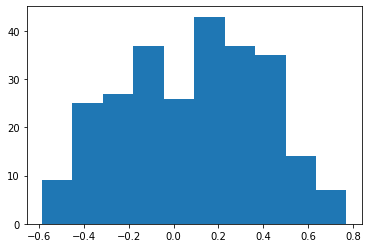

In [29]:
hist(local_pc[0,])

In [ ]:
from scipy.stats import spearmanr, pearsonr

In [ ]:
pearsonr(pc[:,0], sp[:,0])

In [ ]:
hist(pc[:,0])

In [ ]:
hist(sp[:,0])

local p-values

In [ ]:
from numpy import random
from tqdm import tqdm

In [ ]:
rng = random.default_rng()
dist = adata.obsm['proximity']
n_perm = 1000
positive_only = True

In [ ]:
pc = pc.T

In [ ]:
pc.shape

In [ ]:
x_mat.shape

In [ ]:
spot_n = pc.shape[1]  # n of 1:1 edges 
xy_n = pc.shape[0] # n of x-y pairs (e.g. lrs)

# permutation cubes to be populated
local_pvals = np.zeros((xy_n, spot_n))

In [ ]:

for i in tqdm(range(n_perm)):
    _idx = rng.permutation(x_mat.shape[0])
    perm_r = calculate_local_correlations(x_mat[_idx, :], y_mat, weight).T
    if positive_only:
        local_pvals += np.array(perm_r >= pc, dtype=int)
    else:
        local_pvals += (np.array(np.abs(perm_r) >= np.abs(pc), dtype=int))

local_pvals = local_pvals / n_perm

In [ ]:
local_pvals.shape